In [9]:
import sys, os, gc
import numpy as np
import scipy.sparse
import pandas as pd
import tables

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
from lightgbm import LGBMClassifier
from tune_sklearn import TuneSearchCV

In [3]:
#!pip install --quiet tables

In [4]:
sys.path.append('../src/')
from utils import make_cite_train, make_cite_test

In [5]:
# Objective function
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

In [6]:
#DATA_DIR = os.path.join('kaggle/input', os.listdir(kgl_input)[0])
DATA_DIR = '../data'
#os.listdir(DATA_DIR)

In [7]:
PATH_METADATA = os.path.join(DATA_DIR, 'metadata.csv')
PATH_TRAIN_CITE_INPUTS = os.path.join(DATA_DIR, 'train_cite_inputs.h5')
PATH_TRAIN_CITE_TARGETS = os.path.join(DATA_DIR, 'train_cite_targets.h5')

PATH_METADATA2 = os.path.join(DATA_DIR, 'metadata_cite_day_2_donor_27678.csv')
PATH_TEST_CITE_INPUTS = os.path.join(DATA_DIR, 'test_cite_inputs.h5')
PATH_TEST_CITE_INPUTS2 = os.path.join(DATA_DIR, 'test_cite_inputs_day_2_donor_27678.h5')

In [8]:
x_train, y_train, meta_train = make_cite_train(PATH_TRAIN_CITE_INPUTS, PATH_TRAIN_CITE_TARGETS, PATH_METADATA)
gc.collect()

x_test, meta_test = make_cite_test(PATH_TEST_CITE_INPUTS, PATH_TEST_CITE_INPUTS2, PATH_METADATA, PATH_METADATA2)
gc.collect()

0

(5.0, 8.0)

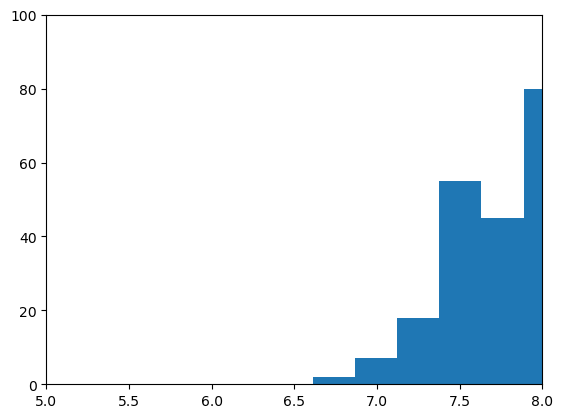

In [28]:
_ = plt.hist(exp(x_train.values[1]) - 1, 200)
plt.ylim(0, 100)
plt.xlim(5, 8)

In [ ]:
x = np.exp(x_train.values) - 1

In [58]:
xx = np.where(x > 0., x, 100000000)

In [62]:
y = np.min(xx, axis=1)

In [72]:
zz = xx / y[..., np.newaxis]

In [76]:
ww = np.where(zz > 1e6, 0, zz)

In [80]:
ww.shape

(70988, 22050)

(-2.0, 10.0)

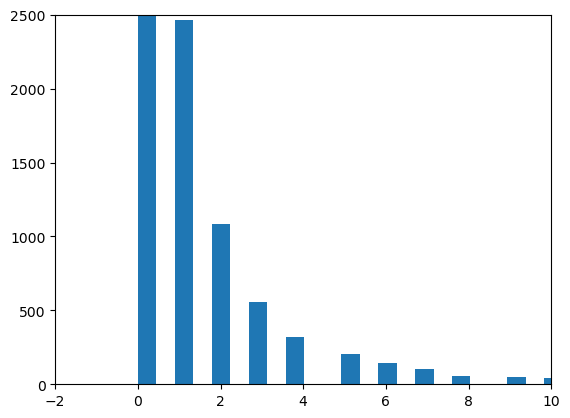

In [98]:
_ = plt.hist(ww[111], 1000)
plt.ylim(0, 2500)
plt.xlim(-2, 10)

In [99]:
wmax = np.max(ww, axis=1)

(0.0, 1000.0)

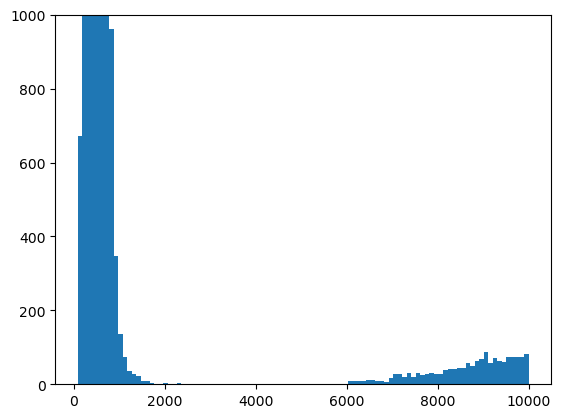

In [103]:
_ = plt.hist(wmax, 100)
#plt.xlim(0, 1600)
plt.ylim(0,1000)


In [40]:
sum(np.exp(x_train.values[100, :]) - 1)

999999.9477539062

In [10]:
meta_df = pd.read_csv(PATH_METADATA)

In [11]:
meta_test[meta_test.day == 7]

,day,donor,cell_type
c0389aaf4d91,7,27678,MasP
a08143be038f,7,27678,HSC
84759d69ca13,7,27678,MasP
a3e96e3bd293,7,27678,MasP
70d4c868ba25,7,27678,HSC
...,...,...,...
a9b4d99f1f50,7,31800,HSC
0e2c1d0782af,7,31800,HSC
a3cbc5aa0ec3,7,31800,MkP
75b350243add,7,31800,EryP


In [9]:
# Add day into feature set
y_train = pd.concat([y_train, meta_train[['day']]], axis=1)

In [10]:
#y_train.drop(columns=['day'], inplace=True)

In [11]:
# Proteins in the training targets (use them now to develop a cell type classification model)
X = scipy.sparse.csr_matrix(y_train)
# Classify cell types based on proteins
Y = meta_train[['cell_type']].astype('category').values

In [12]:
X.shape, Y.shape

((70988, 141), (70988, 1))

In [13]:
lightgbm_params = {
     'boosting_type': 'goss',
     'learning_rate': 0.1, 
     'max_depth': 10, 
     'num_leaves': 200,
     'min_child_samples': 250,
     'colsample_bytree': 0.8, 
     'subsample': 0.6, 
     "seed": 1
    }

In [14]:
%%time

CROSS_VALIDATE = True
if CROSS_VALIDATE:
    y_cols = Y.shape[1] # set this to a small number for a quick test
    n_estimators = 300

    kf = GroupKFold(n_splits=3)
    
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X, groups=meta_train.donor)):
        print('i:', fold, 't:', idx_tr, 'v:', idx_va)

        model = None
        gc.collect()

        X_tr = X[idx_tr]
        y_tr = Y[:,:y_cols][idx_tr]
        X_va = X[idx_va]
        y_va = Y[:,:y_cols][idx_va]

        models, va_preds, va_preds_proba = [], [], []
        for i in range(y_cols):
            print(f"Training column {i:3} for validation")
            model = LGBMClassifier(n_estimators=n_estimators, **lightgbm_params, n_jobs=6)
            # models.append(model) # not needed
            print('fitting')
            model.fit(X_tr, y_tr[:,i].copy())
            print('predicting')
            va_preds.append(model.predict(X_va))
            print('predicting proba')
            va_preds_proba.append(model.predict_proba(X_va))

        y_va_pred = np.column_stack(va_preds) # concatenate the 140 predictions
        y_va_pred_proba = np.column_stack(va_preds_proba) # concatenate the 140 predictions

        del va_preds
        del va_preds_proba
        del X_tr, y_tr, X_va
        gc.collect()
        print('scoring')
        # We validate the model (mse and correlation over all 140 columns)
        #mse = mean_squared_error(y_va, y_va_pred)
        #corrscore = correlation_score(y_va, y_va_pred)
        mse = accuracy_score(y_va, y_va_pred)
        corrscore = accuracy_score(y_va, y_va_pred)
        acc_score = accuracy_score(y_va, y_va_pred)
        #log_score = accuracy_score(y_va, y_va_pred)
        log_score = log_loss(y_va, y_va_pred_proba)
        
        print('Confusion Matrix')
        print(confusion_matrix(y_va, y_va_pred))

        del y_va

        print(f"Fold {fold} {X.shape[1]:4}: mse = {mse:.5f}, acc =  {acc_score:.5f}, log = {log_score: 5f}")
        score_list.append((mse, corrscore, acc_score, log_score))
        #break # We only need the first fold

    if len(score_list) > 1:
        # Show overall score
        result_df = pd.DataFrame(score_list, columns=['mse', 'corrscore', 'acc_score', 'log_score'])
        print(f"Average LGBM mse = {result_df.mse.mean():.5f}; corr = {result_df.corrscore.mean():.5f}; acc = {result_df.acc_score.mean():0.5f}; log = {result_df.log_score.mean():0.5f}")


i: 0 t: [    0     1     2 ... 46182 46183 46184] v: [46185 46186 46187 ... 70985 70986 70987]
Training column   0 for validation
fitting
predicting
predicting proba
scoring
Confusion Matrix
[[   0    1   44    1    4    0    7]
 [   0 4604   27   73  319    0   10]
 [   0    6 9678   34  159    3  378]
 [   0  276  115 1960  225    1  219]
 [   0  364  497  109 1023    0   96]
 [   0   36   25    0   65  134   63]
 [   0    4  549   82   16    4 3592]]
Fold 0  141: mse = 0.84631, acc =  0.84631, log =  0.513242
i: 1 t: [23986 23987 23988 ... 70985 70986 70987] v: [    0     1     2 ... 23983 23984 23985]
Training column   0 for validation
fitting
predicting
predicting proba
scoring
Confusion Matrix
[[   0    6   30    8    6    0    0]
 [   0 4478   21  307  127    1   12]
 [   0   17 9131   28  189    3  384]
 [   0  128   81 2608  174    1  205]
 [   0  239  316  225  608    0   73]
 [   0    4   24    3    4   76   20]
 [   0    6  683  113   27    5 3615]]
Fold 1  141: mse = 0.855

## Optimize hyperparamters

In [19]:
param_dists = {
     'learning_rate': [0.05, 0.2], 
     'max_depth': [5, 20], 
     'num_leaves': [100, 300],
     'min_child_samples': [150, 350],
     'colsample_bytree': [0.6, 0.9], 
     'subsample': [0.5, 0.7]
    }

In [20]:
y = Y[:,0]

In [21]:
lgbm = LGBMClassifier(
    boosting_type='goss',
    n_jobs = 6,
    seed=1
)

lgbm_cv = TuneSearchCV(
    estimator=lgbm,
    param_distributions=param_dists,
    search_optimization="bayesian",
    cv=GroupKFold(n_splits=3),
    scoring = 'accuracy',
    n_trials=10,
    early_stopping=True,
    max_iters=20,
    n_jobs=1,
    verbose=2
)

In [22]:
%%time

lgbm_cv.fit(X, y, groups=meta_train.donor)

(pid=15008) /home/lukas/anaconda3/envs/py310/lib/python3.10/site-packages/tune_sklearn/list_searcher.py:7: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
(pid=15008)   from ray.tune.suggest.suggestion import Searcher
(pid=15008) /home/lukas/anaconda3/envs/py310/lib/python3.10/site-packages/tune_sklearn/list_searcher.py:7: DeprecationWarning: The module `ray.tune.suggest.suggestion` has been moved to `ray.tune.search.searcher` and the old location will be deprecated soon. Please adjust your imports to point to the new location.
(pid=15008) ATTENTION: This module may have been split or refactored. Please check the contents of `ray.tune.search.searcher` before making changes.
(pid=15008)   from ray.tune.suggest.suggestion import Searcher
(pid=15008) /home/lukas/anacon

(pid=26272) /home/lukas/anaconda3/envs/py310/lib/python3.10/site-packages/tune_sklearn/list_searcher.py:7: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
(pid=26272)   from ray.tune.suggest.suggestion import Searcher
(pid=26272) /home/lukas/anaconda3/envs/py310/lib/python3.10/site-packages/tune_sklearn/list_searcher.py:7: DeprecationWarning: The module `ray.tune.suggest.suggestion` has been moved to `ray.tune.search.searcher` and the old location will be deprecated soon. Please adjust your imports to point to the new location.
(pid=26272) ATTENTION: This module may have been split or refactored. Please check the contents of `ray.tune.search.searcher` before making changes.
(pid=26272)   from ray.tune.suggest.suggestion import Searcher
(pid=26272) /home/lukas/anacon

(pid=26621) /home/lukas/anaconda3/envs/py310/lib/python3.10/site-packages/tune_sklearn/list_searcher.py:7: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
(pid=26621)   from ray.tune.suggest.suggestion import Searcher
(pid=26621) /home/lukas/anaconda3/envs/py310/lib/python3.10/site-packages/tune_sklearn/list_searcher.py:7: DeprecationWarning: The module `ray.tune.suggest.suggestion` has been moved to `ray.tune.search.searcher` and the old location will be deprecated soon. Please adjust your imports to point to the new location.
(pid=26621) ATTENTION: This module may have been split or refactored. Please check the contents of `ray.tune.search.searcher` before making changes.
(pid=26621)   from ray.tune.suggest.suggestion import Searcher
(pid=26621) /home/lukas/anacon

(pid=26921) /home/lukas/anaconda3/envs/py310/lib/python3.10/site-packages/tune_sklearn/list_searcher.py:7: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
(pid=26921)   from ray.tune.suggest.suggestion import Searcher
(pid=26921) /home/lukas/anaconda3/envs/py310/lib/python3.10/site-packages/tune_sklearn/list_searcher.py:7: DeprecationWarning: The module `ray.tune.suggest.suggestion` has been moved to `ray.tune.search.searcher` and the old location will be deprecated soon. Please adjust your imports to point to the new location.
(pid=26921) ATTENTION: This module may have been split or refactored. Please check the contents of `ray.tune.search.searcher` before making changes.
(pid=26921)   from ray.tune.suggest.suggestion import Searcher
(pid=26921) /home/lukas/anacon

{'learning_rate': 0.1157890594225776, 'max_depth': 17, 'num_leaves': 239, 'min_child_samples': 182, 'colsample_bytree': 0.6117890970477858, 'subsample': 0.6749928477181312}
{'params': [{'learning_rate': 0.1157890594225776, 'max_depth': 17, 'num_leaves': 239, 'min_child_samples': 182, 'colsample_bytree': 0.6117890970477858, 'subsample': 0.6749928477181312}, {'learning_rate': 0.17583511659304935, 'max_depth': 16, 'num_leaves': 198, 'min_child_samples': 349, 'colsample_bytree': 0.6032250912653214, 'subsample': 0.5887050636322357}, {'learning_rate': 0.08033373947622069, 'max_depth': 17, 'num_leaves': 207, 'min_child_samples': 193, 'colsample_bytree': 0.7150043880203191, 'subsample': 0.5827715550199122}, {'learning_rate': 0.17311724205481518, 'max_depth': 11, 'num_leaves': 142, 'min_child_samples': 236, 'colsample_bytree': 0.7616076046892026, 'subsample': 0.5967911936552674}, {'learning_rate': 0.10158615564375383, 'max_depth': 15, 'num_leaves': 272, 'min_child_samples': 241, 'colsample_bytr

In [23]:
lgbm_cv.cv_results_

{'params': [{'learning_rate': 0.1157890594225776,
   'max_depth': 17,
   'num_leaves': 239,
   'min_child_samples': 182,
   'colsample_bytree': 0.6117890970477858,
   'subsample': 0.6749928477181312},
  {'learning_rate': 0.17583511659304935,
   'max_depth': 16,
   'num_leaves': 198,
   'min_child_samples': 349,
   'colsample_bytree': 0.6032250912653214,
   'subsample': 0.5887050636322357},
  {'learning_rate': 0.08033373947622069,
   'max_depth': 17,
   'num_leaves': 207,
   'min_child_samples': 193,
   'colsample_bytree': 0.7150043880203191,
   'subsample': 0.5827715550199122},
  {'learning_rate': 0.17311724205481518,
   'max_depth': 11,
   'num_leaves': 142,
   'min_child_samples': 236,
   'colsample_bytree': 0.7616076046892026,
   'subsample': 0.5967911936552674},
  {'learning_rate': 0.10158615564375383,
   'max_depth': 15,
   'num_leaves': 272,
   'min_child_samples': 241,
   'colsample_bytree': 0.7456574406747384,
   'subsample': 0.5830647769914692},
  {'learning_rate': 0.142823163

In [25]:
print(lgbm_cv.best_params_)

{'learning_rate': 0.1157890594225776, 'max_depth': 17, 'num_leaves': 239, 'min_child_samples': 182, 'colsample_bytree': 0.6117890970477858, 'subsample': 0.6749928477181312}


In [ ]:
lightgbm_params = {
     'boosting_type': 'goss',
     'learning_rate': 0.1, 
     'max_depth': 10, 
     'num_leaves': 200,
     'min_child_samples': 250,
     'colsample_bytree': 0.8, 
     'subsample': 0.6, 
     "seed": 1
    }

In [22]:
pred = lgbm_cv.predict(X_test)
correct = 0
for i in range(len(y_test)):
    if pred[i] == y_test[i]:
        correct += 1
print("Accuracy:", correct / len(pred))

Accuracy: 0.9736842105263158


In [23]:
gs.cv_results_

{'params': [{'learning_rate': 0.050847414312614324,
   'max_depth': 17,
   'num_leaves': 233,
   'min_child_samples': 333,
   'colsample_bytree': 0.6650951599053373,
   'subsample': 0.5664499007552558},
  {'learning_rate': 0.15671882556207622,
   'max_depth': 7,
   'num_leaves': 207,
   'min_child_samples': 284,
   'colsample_bytree': 0.685689293137132,
   'subsample': 0.5271388959097277},
  {'learning_rate': 0.13893435113882024,
   'max_depth': 18,
   'num_leaves': 261,
   'min_child_samples': 340,
   'colsample_bytree': 0.7197933899906809,
   'subsample': 0.5084740941617972},
  {'learning_rate': 0.10444470952801721,
   'max_depth': 14,
   'num_leaves': 225,
   'min_child_samples': 278,
   'colsample_bytree': 0.790288176096368,
   'subsample': 0.6705123704817287},
  {'learning_rate': 0.10321509580810687,
   'max_depth': 10,
   'num_leaves': 224,
   'min_child_samples': 229,
   'colsample_bytree': 0.7582510650835258,
   'subsample': 0.626682376001814},
  {'learning_rate': 0.19449797385

In [25]:
gs.best_params_

{'learning_rate': 0.2,
 'max_depth': 5,
 'num_leaves': 300,
 'min_child_samples': 150,
 'colsample_bytree': 0.9,
 'subsample': 0.7}

In [26]:
import functools

In [27]:
from functools import singledispatch

In [ ]:
singledispatch()